## FinRL Podracer Learning 

In [41]:

import os
import gym
import torch
import numpy as np
import pandas as pd
from abc import ABC
from numpy import random as rd

gym.logger.set_level(40)  # Block warning: 'WARN: Box bound precision lowered by casting to float32'



In [49]:

class StockEnvNAS89(gym.Env, ABC):
    metadata = {'render.modes': ['human']}  # gym.Env

    def __init__(self, cwd='/home/ga_aiot/FinRL_Podracer/FinRLPodracer/finrl', gamma=0.999, turbulence_thresh=30, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, sell_cost_pct=1e-3,
                 start_date='2008-03-19', end_date='2016-01-01', data_gap=4, reward_scaling=2 ** -13,
                 ticker_list=None, tech_indicator_list=None, initial_stocks=None, if_eval=False):
        cwd = '.'

        self.min_stock_rate = min_stock_rate
        beg_i, mid_i, end_i = 0, int(10 * 2 ** 15), int(528026)  # 62%

        (i0, i1) = (mid_i, end_i) if if_eval else (beg_i, mid_i)
        data_arrays = self.load_data(cwd, ticker_list, tech_indicator_list, start_date, end_date, )
        data_arrays = [ary[i0:i1:data_gap] for ary in data_arrays]
        self.price_ary, self.tech_ary, turbulence_ary = data_arrays

        # if_eval = True
        # self.price_ary: mean, std, min, max = 137, 180, 1.75, 2050
        # self.tech_ary:  mean, std, min, max = 81, 119, -197, 2048
        # turbulence_ary: mean, std, min, max = 1.12, 2.8, 0, 37.5
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockNAS89'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.state_dim = 1 + 2 + 3 * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_discrete = False
        self.target_return = 2.2
        self.episode_return = 0.0

        # gym.Env
        self.observation_space = gym.spaces.Box(low=-500, high=500, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)

    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]

        self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
        self.stocks_cd = np.zeros_like(self.stocks)
        self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * price).sum()

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

    def get_state(self, price):
        amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        return np.hstack((amount,
                          self.turbulence_ary[self.day],
                          self.turbulence_bool[self.day],
                          price * scale,
                          self.stocks * scale,
                          self.stocks_cd,
                          self.tech_ary[self.day],
                          ))  # state.astype(np.float32)

    def load_data(self, cwd='./finrl/', ticker_list=None, tech_indicator_list=None,
                  start_date='2016-01-03', end_date='2021-05-27'):
        data_name = 'NAS89_minute'
        raw_data1_path = f'{cwd}/StockEnv_{data_name}_raw_data1.df'
        raw_data2_path = f'{cwd}/StockEnv_{data_name}_raw_data2.df'
        data_path_array = f'{cwd}/StockEnv_{data_name}_arrays_float16.npz'
        data_turb_array = f'{cwd}/StockEnv_{data_name}_turbulence.npy'

        turbulence_ary = np.load(data_turb_array)  # turbulence_ary.shape = (1358, ). std, min, max = 3, 0, 65.2
        turbulence_ary = turbulence_ary.repeat(390)  # 13580*390 = 529620
        turbulence_ary = turbulence_ary[-528026:]  # 15926 + 528026 = 528026

        tech_indicator_list = [
            'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma'
        ] if tech_indicator_list is None else tech_indicator_list
        # tech_indicator_list = [
        #     'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'
        # ] if tech_indicator_list is None else tech_indicator_list

        # ticker_list = [
        #     'AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD',
        #     'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD',
        #     'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD'
        # ] if ticker_list is None else ticker_list  # finrl.config.DOW_30_TICKER
        ticker_list = [
            'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'ALXN', 'AMAT', 'AMD', 'AMGN',
            'AMZN', 'ASML', 'ATVI', 'BIIB', 'BKNG', 'BMRN', 'CDNS', 'CERN', 'CHKP', 'CMCSA',
            'COST', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'DLTR', 'EA', 'EBAY', 'FAST',
            'FISV', 'GILD', 'HAS', 'HSIC', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG',
            'JBHT', 'KLAC', 'LRCX', 'MAR', 'MCHP', 'MDLZ', 'MNST', 'MSFT', 'MU', 'MXIM',
            'NLOK', 'NTAP', 'NTES', 'NVDA', 'ORLY', 'PAYX', 'PCAR', 'PEP', 'QCOM', 'REGN',
            'ROST', 'SBUX', 'SIRI', 'SNPS', 'SWKS', 'TTWO', 'TXN', 'VRSN', 'VRTX', 'WBA',
            'WDC', 'WLTW', 'XEL', 'XLNX'
        ] if ticker_list is None else ticker_list  # finrl.config.NAS_74_TICKER
        # ticker_list = [
        #     'AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX',
        #     'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP',
        #     'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX',
        #     'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MYL', 'MU',
        #     'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC',
        #     'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA',
        #     'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM',
        #     'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS',
        #     'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO',
        #     'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL'
        # ] if ticker_list is None else ticker_list  # finrl.config.NAS_100_TICKER

        # print(raw_df.loc['2000-01-01'])
        # j = 40000
        # check_ticker_list = set(raw_df.loc.obj.tic[j:j + 200].tolist())
        # print(len(check_ticker_list), check_ticker_list)

        '''get: train_price_ary, train_tech_ary, eval_price_ary, eval_tech_ary'''
        if os.path.exists(data_path_array):
            load_dict = np.load(data_path_array, allow_pickle=True)

            price_ary = load_dict['price_ary'].astype(np.float32)
            tech_ary = load_dict['tech_ary'].astype(np.float32)
            # turbulence_ary = load_dict['turbulence_ary'].astype(np.float32)
        else:
            raw_data2_df = self.get_raw_data2(raw_data1_path, raw_data2_path,
                                              ticker_list, tech_indicator_list)

            # def data_split(df, start, end):
            #     data = df[(df.date >= start) & (df.date < end)]
            #     data = data.sort_values(["date", "tic"], ignore_index=True)
            #     data.index = data.date.factorize()[0]
            #     return data
            print("| start_date, end_date:", start_date, end_date)
            # train_df = data_split(raw_data2_df, start_date, end_date)

            # print(raw_data2_df.date)  # to show the start_date and end_date
            # print(raw_data2_df.columns)  # to show the items name
            price_ary, tech_ary = self.convert_df_to_ary(raw_data2_df, tech_indicator_list)
            price_ary, tech_ary = self.deal_with_split_or_merge_shares(price_ary, tech_ary)

            np.savez_compressed(data_path_array,
                                price_ary=price_ary.astype(np.float16),
                                tech_ary=tech_ary.astype(np.float16), )

        return price_ary, tech_ary, turbulence_ary

    def get_raw_data2(self, raw_data1_path, raw_data2_path,
                      ticker_list, tech_indicator_list):
        if os.path.exists(raw_data2_path):
            processed_df = pd.read_pickle(raw_data2_path)  # DataFrame of Pandas
            # print('| processed_df.columns.values:', processed_df.columns.values)
            print(f"| load data: {raw_data2_path}")
        else:
            print("| FeatureEngineer: start processing data (2 minutes)")
            fe = FeatureEngineer(use_turbulence=True,
                                 user_defined_feature=False,
                                 use_technical_indicator=True,
                                 tech_indicator_list=tech_indicator_list, )
            raw_df = self.get_raw_data(raw_data1_path, ticker_list)

            processed_df = fe.preprocess_data(raw_df)
            processed_df.to_pickle(raw_data2_path)
            print("| FeatureEngineer: finish processing data")

        '''you can also load from csv'''
        # processed_data_path = f'{cwd}/dow_30_2021_minute.csv'
        # processed_data_path = f'{cwd}/dow_30_daily_2000_2021.csv'
        # if os.path.exists(processed_data_path):
        #     processed_df = pd.read_csv(processed_data_path)
        return processed_df

    def draw_cumulative_return(self, args, _torch) -> list:
        state_dim = self.state_dim
        action_dim = self.action_dim

        agent = args.agent
        net_dim = args.net_dim
        cwd = args.cwd

        agent.init(net_dim, state_dim, action_dim)
        agent.save_or_load_policy(cwd=cwd, if_save=False)
        act = agent.act
        device = agent.device

        state = self.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        with _torch.no_grad():
            for i in range(self.max_step):
                s_tensor = _torch.as_tensor((state,), device=device)
                a_tensor = act(s_tensor)  # action_tanh = act.forward()
                action = a_tensor.detach().cpu().numpy()[0]  # not need detach(), because with torch.no_grad() outside
                state, reward, done, _ = self.step(action)

                total_asset = self.amount + (self.price_ary[self.day] * self.stocks).sum()
                episode_return = total_asset / self.initial_total_asset
                episode_returns.append(episode_return)
                if done:
                    break

        import matplotlib.pyplot as plt
        plt.plot(episode_returns)
        plt.grid()
        plt.title('cumulative return')
        plt.xlabel('day')
        plt.xlabel('multiple of initial_account')
        plt.savefig(f'{cwd}/cumulative_return.jpg')
        print(f"| draw_cumulative_return: save in {cwd}/cumulative_return.jpg")
        return episode_returns

    def deal_with_split_or_merge_shares(self, price_ary, tech_ary):
        # print(price_ary.shape)  # (528026, 93)
        # print(tech_ary.shape)  # (528026, 93 * 7)
        tech_ary = tech_ary.reshape((tech_ary.shape[0], -1, 7))

        data_idx = list(range(price_ary.shape[1]))
        # for delete_idx in (77, 36, 31, 14):
        #     del data_idx[delete_idx]
        # data_idx = np.array(data_idx)

        price_ary = price_ary[:, data_idx]
        tech_ary = tech_ary[:, data_idx, :]
        for j in range(price_ary.shape[1]):
            x = price_ary[:, j]

            x = self.fill_nan_with_next_value(x)  # fill_nan_with_next_value

            x_offset0 = x[1:]
            x_offset1 = x[:-1]
            x_delta = np.abs(x_offset0 - x_offset1) / ((x_offset0 * x_offset1) ** 0.5)
            x_where = np.where(x_delta > 0.25)[0]
            # plt.plot(x)
            for i in x_where:
                # print(j, i, x[i] / x[i + 1])
                x[i + 1:] *= x[i] / x[i + 1]
            # plt.plot(x)
            # plt.show()
            price_ary[:, j] = x

        # print(price_ary.shape)  # (528026, 89)

        for tech_i1 in range(tech_ary.shape[1]):  # fill_nan_with_next_value
            for tech_i2 in range(tech_ary.shape[2]):
                tech_item = tech_ary[:, tech_i1, tech_i2]
                tech_item = self.fill_nan_with_next_value(tech_item)
                tech_ary[:, tech_i1, tech_i2] = tech_item

        tech_ary = tech_ary.reshape((528026, -1))
        # print(tech_ary.shape)  # (528026, 89 * 7)
        return price_ary, tech_ary

    @staticmethod
    def fill_nan_with_next_value(ary):
        x_isnan = np.isnan(ary)
        value = ary[np.where(~x_isnan)[0][0]]  # find the first value != nan
        for k in range(ary.shape[0]):
            if x_isnan[k]:
                ary[k] = value
            value = ary[k]
        return ary

    @staticmethod
    def get_raw_data(raw_data_path, ticker_list):
        if os.path.exists(raw_data_path):
            raw_df = pd.read_pickle(raw_data_path)  # DataFrame of Pandas
            # print('| raw_df.columns.values:', raw_df.columns.values)
            print(f"| load data: {raw_data_path}")
        else:
            print("| YahooDownloader: start downloading data (1 minute)")
            raw_df = YahooDownloader(start_date="2000-01-01",
                                     end_date="2021-01-01",
                                     ticker_list=ticker_list, ).fetch_data()
            raw_df.to_pickle(raw_data_path)
            print("| YahooDownloader: finish downloading data")
        return raw_df

    @staticmethod
    def convert_df_to_ary(df, tech_indicator_list):
        tech_ary = list()
        price_ary = list()

        for day in range(len(df.index.unique())):
            item = df.loc[day]

            tech_items = [item[tech].values.tolist() for tech in tech_indicator_list]
            tech_items_flatten = sum(tech_items, [])
            tech_ary.append(tech_items_flatten)
            price_ary.append(item.close)  # adjusted close price (adjcp)
            print(';;', type(item.turbulence), len(item.turbulence))

        tech_ary = np.array(tech_ary)
        price_ary = np.array(price_ary)
        print(f'| ary.shape price, tech, turbulence: {price_ary.shape} {tech_ary.shape}')
        return price_ary, tech_ary

    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh




In [43]:
def check_stock_trading_env():
    if_eval = True  # False

    env = StockEnvNAS89(if_eval=if_eval)
    action_dim = env.action_dim

    state = env.reset()
    print('| check_stock_trading_env, state_dim', len(state))

    from time import time
    timer = time()

    # ============================================================
    policy_name = 'Random Action 1e-2'
    step = 1
    done = False
    episode_return = 0

    env.reset()
    while not done:
        action = rd.uniform(-1, 1, size=action_dim) * 1e-2

        next_state, reward, done, _ = env.step(action)
        episode_return += reward
        step += 1

    print()
    print(f"| {policy_name}:")
    print(f"| step {step}, UsedTime {time() - timer:.3e}")
    print(f"| gamma_reward \t\t\t{env.gamma_reward:.3e}")
    print(f"| episode return \t\t{episode_return:.3e}")
    print(f"| discount return \t\t{episode_return / step / (1 - env.gamma):.3e}")
    print(f"| env episode return \t{env.episode_return:.3e}")

    # ============================================================
    policy_name = 'Buy  4 Action'
    step = 1
    done = False
    episode_return = 0

    env.reset()
    while not done:
        action = np.zeros(action_dim)
        action[:3] = 1

        next_state, reward, done, _ = env.step(action)
        episode_return += reward
        step += 1

    print()
    print(f"| {policy_name}:")
    print(f"| step {step}, UsedTime {time() - timer:.3e}")
    print(f"| gamma_reward \t\t\t{env.gamma_reward:.3e}")
    print(f"| episode return \t\t{episode_return:.3e}")
    print(f"| discount return \t\t{episode_return / step / (1 - env.gamma):.3e}")
    print(f"| env episode return \t{env.episode_return:.3e}")

    # ============================================================
    '''draw_cumulative_return'''
    # from FinRLPodracer.elegantrl.agent import AgentPPO
    # from FinRLPodracer.elegantrl.run import Arguments
    # args = Arguments(if_on_policy=True)
    # args.agent = AgentPPO()
    # args.env = StockEnvNAS89(if_eval=True)
    # args.if_remove = False
    # args.cwd = './StockTradingEnv-v1_AgentPPO'
    # args.init_before_training()
    #
    # env.draw_cumulative_return(args, torch)




In [44]:
### YFinance Class for FE 
"""Copy from finrl"""
class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    from finrl.marketdata.yahoodownloader import YahooDownloader

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):

        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self) -> pd.DataFrame:
        import yfinance as yf  # Yahoo Finance
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        for tic in self.ticker_list:
            temp_df = yf.download(tic, start=self.start_date, end=self.end_date)
            temp_df["tic"] = tic
            data_df = data_df.append(temp_df)
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop("adjcp", 1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=['date', 'tic']).reset_index(drop=True)

        return data_df




In [45]:
## The FE Class
class FeatureEngineer:
    """Provides methods for preprocessing the stock price data
    from finrl.preprocessing.preprocessors import FeatureEngineer

    Attributes
    ----------
        use_technical_indicator : boolean
            we technical indicator or not
        tech_indicator_list : list
            a list of technical indicator names (modified from config.py)
        use_turbulence : boolean
            use turbulence index or not
        user_defined_feature:boolean
            user user defined features or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

    """

    def __init__(
            self,
            use_technical_indicator=True,
            tech_indicator_list=None,  # config.TECHNICAL_INDICATORS_LIST,
            use_turbulence=False,
            user_defined_feature=False,
    ):
        self.use_technical_indicator = use_technical_indicator
        self.tech_indicator_list = tech_indicator_list
        self.use_turbulence = use_turbulence
        self.user_defined_feature = user_defined_feature

    def preprocess_data(self, df):
        """main method to do the feature engineering
        @:param config: source dataframe
        @:return: a DataMatrices object
        """

        if self.use_technical_indicator:
            # add technical indicators using stockstats
            df = self.add_technical_indicator(df)
            print("Successfully added technical indicators")

        # add turbulence index for multiple stock
        if self.use_turbulence:
            df = self.add_turbulence(df)
            print("Successfully added turbulence index")

        # add user defined feature
        if self.user_defined_feature:
            df = self.add_user_defined_feature(df)
            print("Successfully added user defined features")

        # fill the missing values at the beginning and the end
        df = df.fillna(method="bfill").fillna(method="ffill")
        return df

    def add_technical_indicator(self, data):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        from stockstats import StockDataFrame as Sdf  # for Sdf.retype

        df = data.copy()
        df = df.sort_values(by=['tic', 'date'])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in self.tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator['tic'] = unique_ticker[i]
                    temp_indicator['date'] = df[df.tic == unique_ticker[i]]['date'].to_list()
                    indicator_df = indicator_df.append(
                        temp_indicator, ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(indicator_df[['tic', 'date', indicator]], on=['tic', 'date'], how='left')
        df = df.sort_values(by=['date', 'tic'])
        return df

    def add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    @staticmethod
    def add_user_defined_feature(data):
        """
         add user defined features
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df["daily_return"] = df.close.pct_change(1)
        # df['return_lag_1']=df.close.pct_change(2)
        # df['return_lag_2']=df.close.pct_change(3)
        # df['return_lag_3']=df.close.pct_change(4)
        # df['return_lag_4']=df.close.pct_change(5)
        return df

    @staticmethod
    def calculate_turbulence(data):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="date", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.date.unique()
        # start after a year
        start = 252
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - 252])
                ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[hist_price.isna().sum().min():].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(filtered_hist_price, axis=0)
            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)

        turbulence_index = pd.DataFrame(
            {"date": df_price_pivot.index, "turbulence": turbulence_index}
        )
        return turbulence_index




In [46]:
"""Load and Run finrl Agent"""


def load_and_run_agent():
    import matplotlib.pyplot as plt
    from tqdm import trange

    # cwd = '/home/yonv/code/ElegantRL/StockNAS74_1.45'
    # env = StockEnvNAS74(if_eval=True, turbulence_thresh=700, min_stock_rate=0.0)
    # save_path = './nas74-daily.df'
    cwd = '/home/ga_aiot/FinRL_Podracer/FinRLPodracer/model'
    env = StockEnvNAS89(if_eval=True, turbulence_thresh=15, min_stock_rate=0.12)
    save_path = '/home/ga_aiot/FinRL_Podracer/FinRLPodracer/model/nas89-minute-.df'

    max_step = env.max_step
    state_dim = env.state_dim
    action_dim = env.action_dim

    '''RL-PPO'''
    policy_name = 'RL-PPO'
    if policy_name:
        net_dim = 2 ** 9  # todo
        import sys
        import os
        #from elegantrl.agent import AgentPPO
        #sys.path.append('./FinRL_Podracer/FinRLPodracer/elegantrl/agent.py')

        e2 = os.path.abspath('/home/ga_aiot/FinRL_Podracer/FinRLPodracer/elegantrl/')
        sys.path.append(e2)
        from agent2 import AgentPPO
        agent = AgentPPO()
        #agent = AgentBase()
        agent.init(net_dim, state_dim, action_dim)
        agent.save_or_load_agent(cwd, if_save=False)

        state = env.reset()
        return_list = list()
        for _ in trange(max_step):
            env.amount *= 1.000223
            tensor_state = torch.as_tensor((state,), dtype=torch.float32, device=agent.device)
            tensor_action = agent.act(tensor_state)
            action = tensor_action.detach().cpu().numpy()[0]
            state, reward, done, _ = env.step(action)

            return_list.append(env.total_asset / env.initial_total_asset)

        plt.plot(return_list[:-1], label=policy_name)
        print(f'| episode return {policy_name:>16}: {env.episode_return:.3f}')
        df_value = pd.DataFrame({'account_value': return_list})
        df_value.to_pickle(save_path)
        print('| Save in', save_path)

    policy_name = 0  # 'keepBuying 32'
    if policy_name:
        env.reset()
        action = np.zeros(action_dim, dtype=np.float32)
        action[64:] = 1
        return_list = list()
        for _ in trange(max_step):
            state, reward, done, _ = env.step(action)
            return_list.append(env.total_asset / env.initial_total_asset)
        plt.plot(return_list[:-1], label=policy_name)
        print(f'| episode return {policy_name:>16}: {env.episode_return:.3f}')

    policy_name = 0  # 'random action'
    if policy_name:
        env.reset()
        return_list = list()
        for _ in trange(max_step):
            action = rd.rand(action_dim) * 2 - 1
            state, reward, done, _ = env.step(action)
            return_list.append(env.total_asset / env.initial_total_asset)
        plt.plot(return_list[:-1], label=policy_name)
        print(f'| episode return {policy_name:>16}: {env.episode_return:.3f}')

    plt.legend()
    plt.grid()
    plt.show()


In [47]:
if __name__ == '__main__':
    check_stock_trading_env()
    
    #load_and_run_agent()
    # StockEnvNAS74()

| check_stock_trading_env, state_dim 893

| Random Action 1e-2:
| step 50087, UsedTime 1.515e+00
| gamma_reward 			-2.237e-13
| episode return 		7.300e+00
| discount return 		1.457e-01
| env episode return 	1.062e+00

| Buy  4 Action:
| step 50087, UsedTime 3.511e+00
| gamma_reward 			2.273e+00
| episode return 		1.253e+02
| discount return 		2.501e+00
| env episode return 	1.975e+00


100%|███████████████████████████████████████████████████████████████████████████| 50086/50086 [00:38<00:00, 1300.65it/s]


| episode return           RL-PPO: 2.836
| Save in /home/ga_aiot/FinRL_Podracer/FinRLPodracer/model/nas89-minute-.df


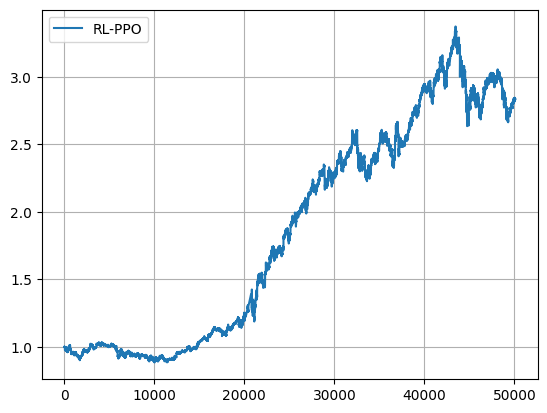

In [50]:
load_and_run_agent()